## Problem Statement

The objective of this project is to leverage supervised machine learning to predict whether an individual is a user of illicit drugs based on demographic attributes, personality traits, and behavioral characteristics. The task is a binary classification where the target variable indicates drug use (1 for user, 0 for non-user).

This project addresses substance abuse, a significant public health issue with far-reaching social, psychological, and economic consequences. By identifying strong predictors of drug use and evaluating model performance, this project aims to:
1. Provide actionable insights for targeted interventions.
2. Inform educational programs and public health policies.
3. Develop a model to accurately predict if an individual is at risk for drug use/abuse, using key metrics such as precision, recall, and F1-score.

### Models Used
The following machine learning models were evaluated for their ability to predict drug use:
1. Logistic Regression: For its simplicity and interpretability in identifying significant predictors.
2. Random Forest: For handling non-linear relationships and feature importance analysis.
3. Support Vector Machine: For its ability to handle high-dimensional data and non-linear boundaries.
4. k-Nearest Neighbor: For capturing local patterns and simplicity in implementation.

### Dataset
The data used for this project is the "Drug Consumption (Quantified)" dataset:
Fehrman, E., Egan, V., & Mirkes, E. (2015). Drug Consumption (Quantified) [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5TC7S


In [1]:
# Import required libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [2]:
# Fetch dataset
drug_consumption_quantified = fetch_ucirepo(id=373)

# Load data as Pandas DataFrames
X = drug_consumption_quantified.data.features
y = drug_consumption_quantified.data.targets

# Merge features and targets into a single DataFrame
df = pd.concat([X, y], axis=1)

### **Data Cleanup**
Here we'll do some slight cleaning of the data by fixing a typo in the dataset and dropping an irrelevant column

In [3]:
# Fix column name
df = df.rename(columns={'impuslive': 'impulsive'})

# Drop irrelevant column
df = df.drop(columns=['semer'])

### **Load and Preview the Data**

Understand the dataset structure and summarize it

In [4]:
# Check the structure of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1885 non-null   float64
 1   gender     1885 non-null   float64
 2   education  1885 non-null   float64
 3   country    1885 non-null   float64
 4   ethnicity  1885 non-null   float64
 5   nscore     1885 non-null   float64
 6   escore     1885 non-null   float64
 7   oscore     1885 non-null   float64
 8   ascore     1885 non-null   float64
 9   cscore     1885 non-null   float64
 10  impulsive  1885 non-null   float64
 11  ss         1885 non-null   float64
 12  alcohol    1885 non-null   object 
 13  amphet     1885 non-null   object 
 14  amyl       1885 non-null   object 
 15  benzos     1885 non-null   object 
 16  caff       1885 non-null   object 
 17  cannabis   1885 non-null   object 
 18  choc       1885 non-null   object 
 19  coke       1885 non-null   object 
 20  crack   

In [5]:
# Check for missing values
print(df.isnull().sum())

age          0
gender       0
education    0
country      0
ethnicity    0
nscore       0
escore       0
oscore       0
ascore       0
cscore       0
impulsive    0
ss           0
alcohol      0
amphet       0
amyl         0
benzos       0
caff         0
cannabis     0
choc         0
coke         0
crack        0
ecstasy      0
heroin       0
ketamine     0
legalh       0
lsd          0
meth         0
mushrooms    0
nicotine     0
vsa          0
dtype: int64


In [6]:
# Preview the dataset
print(df.head())

       age   gender  education  country  ethnicity   nscore   escore   oscore  \
0  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545 -0.58331   
1 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886  1.43533   
2  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523 -0.84732   
3 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615 -0.01928   
4  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340 -0.45174   

    ascore   cscore  ...  crack  ecstasy heroin ketamine legalh  lsd meth  \
0 -0.91699 -0.00665  ...    CL0      CL0    CL0      CL0    CL0  CL0  CL0   
1  0.76096 -0.14277  ...    CL0      CL4    CL0      CL2    CL0  CL2  CL3   
2 -1.62090 -1.01450  ...    CL0      CL0    CL0      CL0    CL0  CL0  CL0   
3  0.59042  0.58489  ...    CL0      CL0    CL0      CL2    CL0  CL0  CL0   
4 -0.30172  1.30612  ...    CL0      CL1    CL0      CL0    CL1  CL0  CL0   

  mushrooms nicotine  vsa  
0       CL0      CL2  

In [7]:
df.columns

Index(['age', 'gender', 'education', 'country', 'ethnicity', 'nscore',
       'escore', 'oscore', 'ascore', 'cscore', 'impulsive', 'ss', 'alcohol',
       'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack',
       'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms',
       'nicotine', 'vsa'],
      dtype='object')

Data Description

In [8]:
# Dataset Overview
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes.value_counts())

# Summary of numerical columns
df.describe()

# Count unique values in categorical columns
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique values")


Dataset Shape: (1885, 30)

Data Types:
object     18
float64    12
Name: count, dtype: int64
alcohol: 7 unique values
amphet: 7 unique values
amyl: 7 unique values
benzos: 7 unique values
caff: 7 unique values
cannabis: 7 unique values
choc: 7 unique values
coke: 7 unique values
crack: 7 unique values
ecstasy: 7 unique values
heroin: 7 unique values
ketamine: 7 unique values
legalh: 7 unique values
lsd: 7 unique values
meth: 7 unique values
mushrooms: 7 unique values
nicotine: 7 unique values
vsa: 7 unique values


### Data Cleaning

#### Missing Values
- The dataset contains no missing values

#### Outliers
- There were no significant outliers

#### Class Imbalance
- The target variable was ever so slightly imbalanced, with 58.7% users and 41.3% non-users.

### Conclusions
- The cleaned dataset contains no missing values or extreme outliers.


### **Understand the Target Variable**

Before diving into predictors, analyze the distribution of the target variable (`y`).

In [9]:
# Define a list of drugs (update based on your analysis)
drugs = ['cannabis', 'coke', 'crack', 'heroin', 'meth', 'ecstasy', 
        'lsd', 'amyl', 'ketamine', 'mushrooms', 'vsa']

# Use at least once in last year
drug_user = ['CL3', 'CL4', 'CL5', 'CL6']

# Define a binary target variable for any drug use in the last year
def check_drug_use(row):
    for user in drug_user:  # Iterate over the drug_user codes
        if user in row.values:  # Check if the code is in the row's values
            return 1  # Return 1 if a match is found
    return 0  # Return 0 if no matches are found

# Apply the function only to the specified drug columns
df['drug_use'] = df[drugs].apply(check_drug_use, axis=1)

dfDrugUse = df.drop(columns={'alcohol',
       'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack',
       'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms',
       'nicotine', 'vsa'})
dfDrugUse.head()


,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss,drug_use
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,1


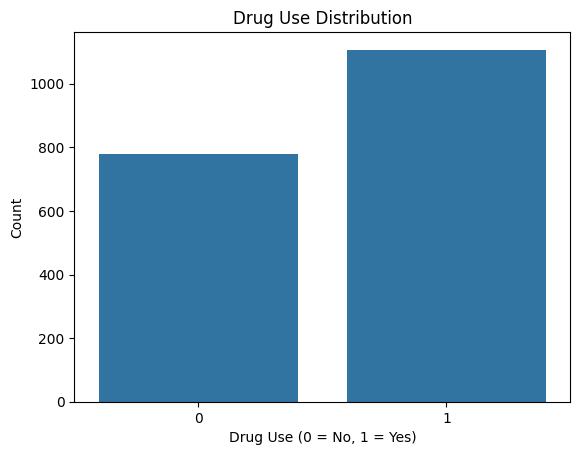

In [10]:
# Plot the new binary target variable
sns.countplot(x=df['drug_use'], y=None, hue=None, data=df)
plt.title("Drug Use Distribution")
plt.xlabel("Drug Use (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

### **Overview of the Target Variable**

-   Start by checking the distribution of the binary target variable to ensure no severe class imbalance.

In [11]:
# Check class distribution
print(df['drug_use'].value_counts(normalize=True))


drug_use
1    0.587268
0    0.412732
Name: proportion, dtype: float64


Mapping Fields for Better Interpretability

In [12]:
# Mapping age values to age groups
age_mapping = {
    -0.95197: "18-24",
    -0.07854: "25-34",
     0.49788: "35-44",
     1.09449: "45-54",
     1.82213: "55-64",
     2.59171: "65+"
}

gender_mapping = {
    0.48246: "Female",
   -0.48246: "Male"
}

education_mapping = {
    -2.43591: "Left before 16",
    -1.73790: "Left at 16",
    -1.43719: "Left at 17",
    -1.22751: "Left at 18",
    -0.61113: "Some college",
    -0.05921: "Professional cert",
     0.45468: "University degree",
     1.16365: "Masters degree",
     1.98437: "Doctorate"
}

country_mapping = {
    -0.09765: "Australia",
     0.24923: "Canada",
    -0.46841: "New Zealand",
    -0.28519: "Other",
     0.21128: "Ireland",
     0.96082: "UK",
    -0.57009: "USA"
}

ethnicity_mapping = {
    -0.50212: "Asian",
    -1.10702: "Black",
     1.90725: "Mixed-Black/Asian",
     0.12600: "Mixed-White/Asian",
    -0.22166: "Mixed-White/Black",
     0.11440: "Other",
    -0.31685: "White"
}

### **Create a Mapped DataFrame for Visualizations**

Copy the original `df` to a new DataFrame, `dfMapped`, and apply the mappings only to this new DataFrame.

In [13]:
# Create a separate DataFrame for mapped values
dfMapped = df.copy()

# Apply mappings to the copied DataFrame for visualizations
dfMapped['age'] = dfMapped['age'].map(age_mapping)
dfMapped['gender'] = dfMapped['gender'].map(gender_mapping)
dfMapped['education'] = dfMapped['education'].map(education_mapping)
dfMapped['country'] = dfMapped['country'].map(country_mapping)
dfMapped['ethnicity'] = dfMapped['ethnicity'].map(ethnicity_mapping)


### **Feature Distribution by Illicit Drug Use**

-   Analyze the distribution of demographic and personality traits with respect to `illicit_drug_use`.

a. Demographics

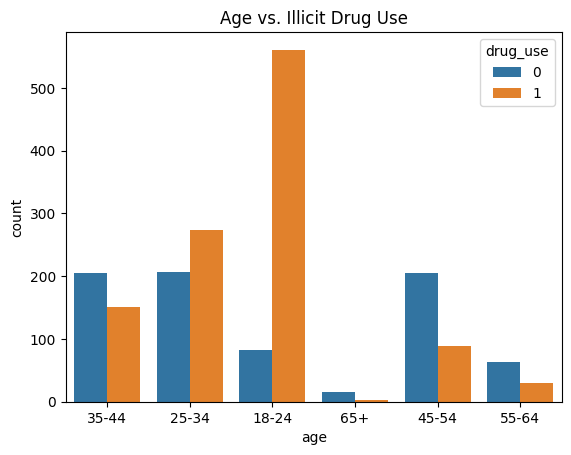

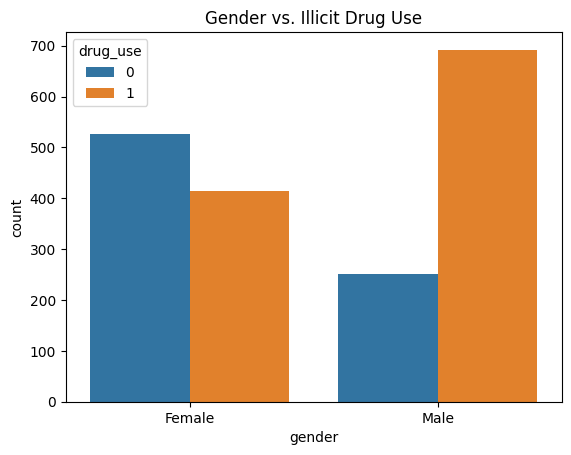

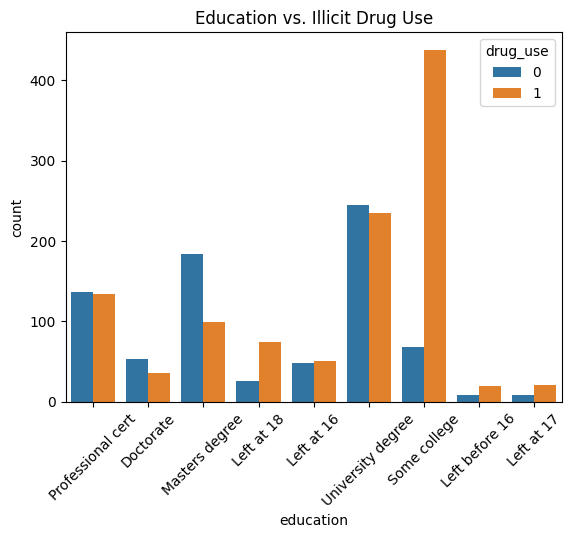

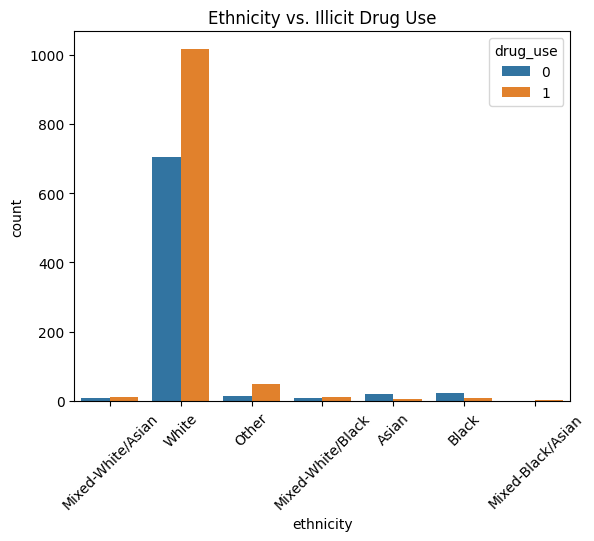

In [ ]:
# Visualize age distribution by illicit drug use
sns.countplot(data=dfMapped, x='age', hue=df['drug_use'])
plt.title("Age vs. Illicit Drug Use")
plt.show()

# Visualize gender distribution by illicit drug use
sns.countplot(data=dfMapped, x='gender', hue=df['drug_use'])
plt.title("Gender vs. Illicit Drug Use")
plt.show()

# Visualize education distribution by illicit drug use
sns.countplot(data=dfMapped, x='education', hue=df['drug_use'])
plt.title("Education vs. Illicit Drug Use")
plt.xticks(rotation=45)
plt.show()

# Visualize ethnicity distribution by illicit drug use
sns.countplot(data=dfMapped, x='ethnicity', hue=df['drug_use'])
plt.title("Ethnicity vs. Illicit Drug Use")
plt.xticks(rotation=45)
plt.show()


b. Personality Traits

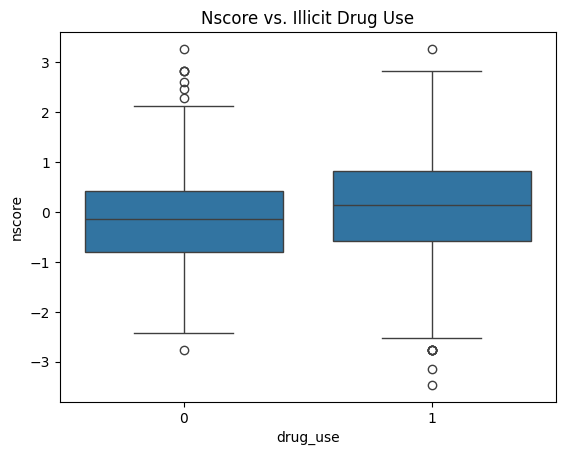

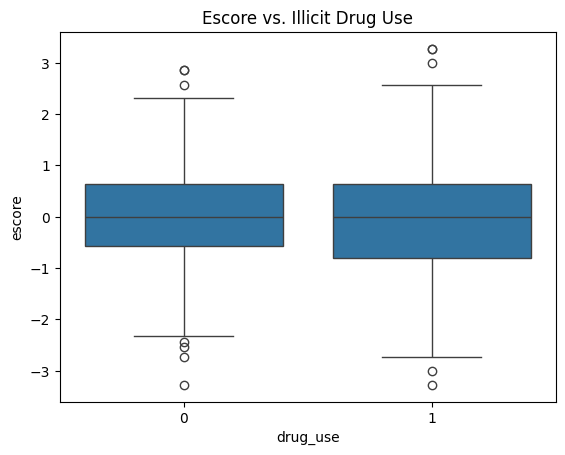

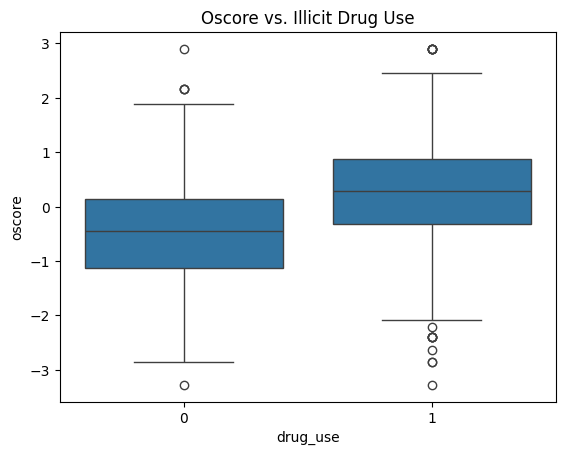

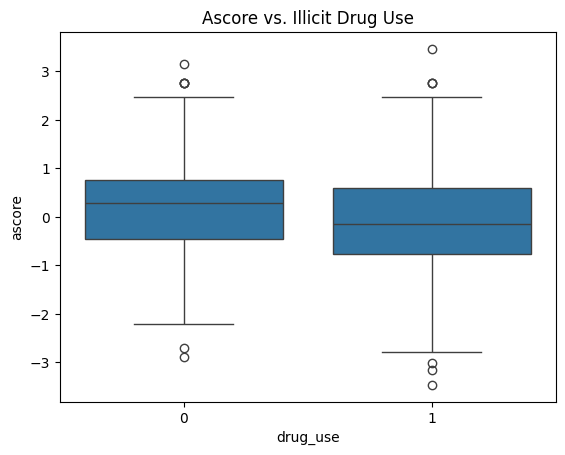

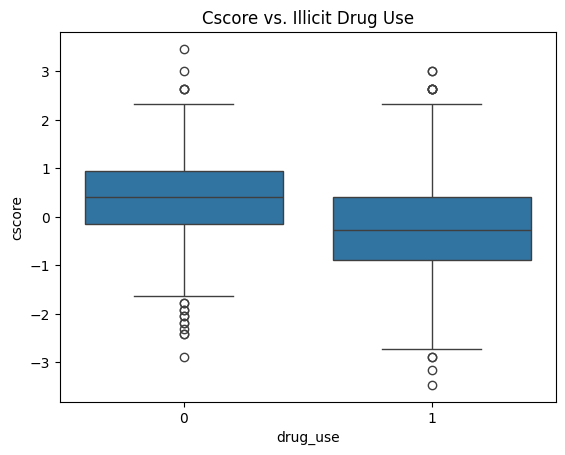

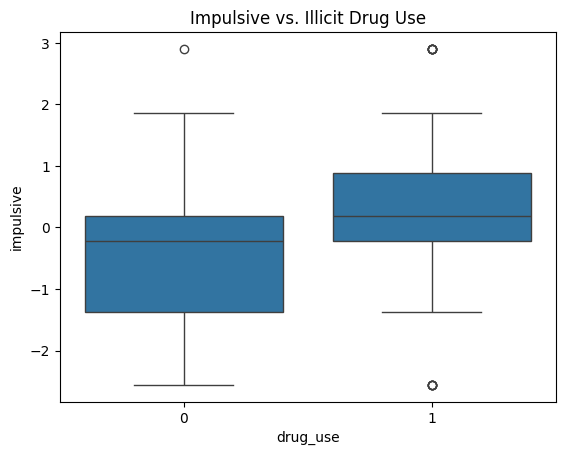

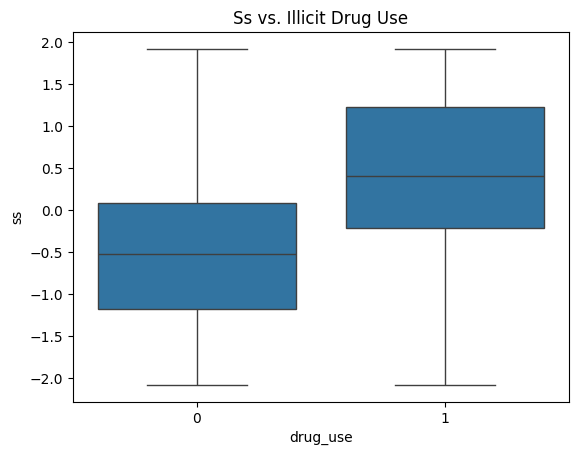

In [15]:
# Box plots for personality traits by illicit drug use
traits = ['nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impulsive', 'ss']

for trait in traits:
    sns.boxplot(data=df, x=df['drug_use'], y=trait)
    plt.title(f"{trait.capitalize()} vs. Illicit Drug Use")
    plt.show()


### **Correlation Analysis**

-   Analyze the correlation between numerical features and `illicit_drug_use` to identify strong predictors.

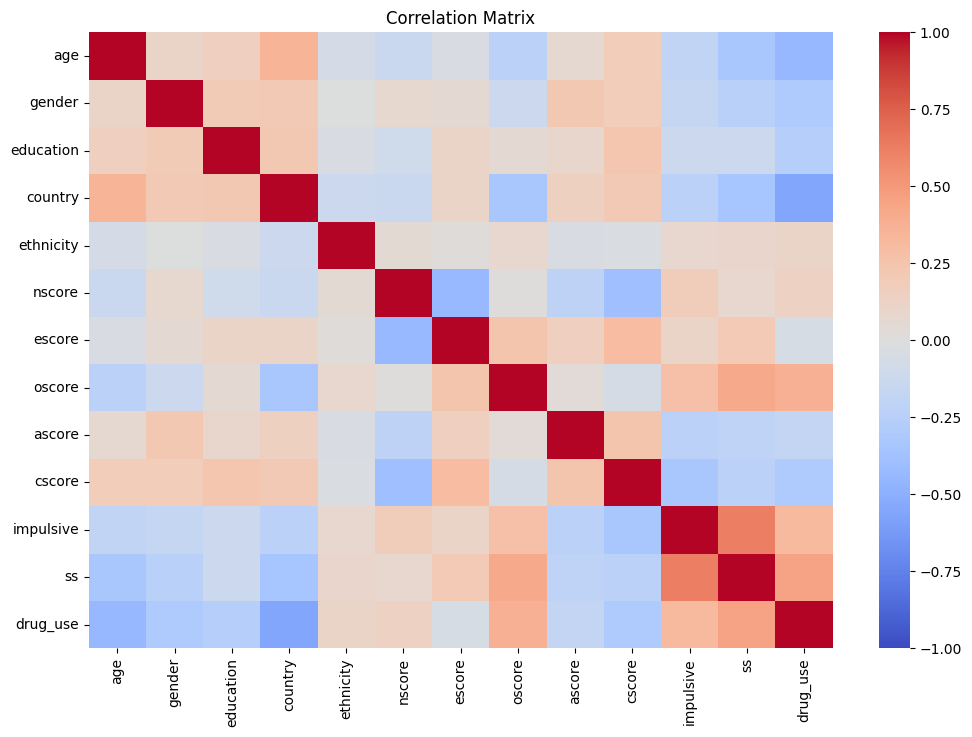

In [16]:
# Compute correlation matrix
correlation_matrix = dfDrugUse.corr()

# Plot heatmap for correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


### **Pairwise Relationships**

-   Use pair plots to explore how key features relate to `illicit_drug_use`.

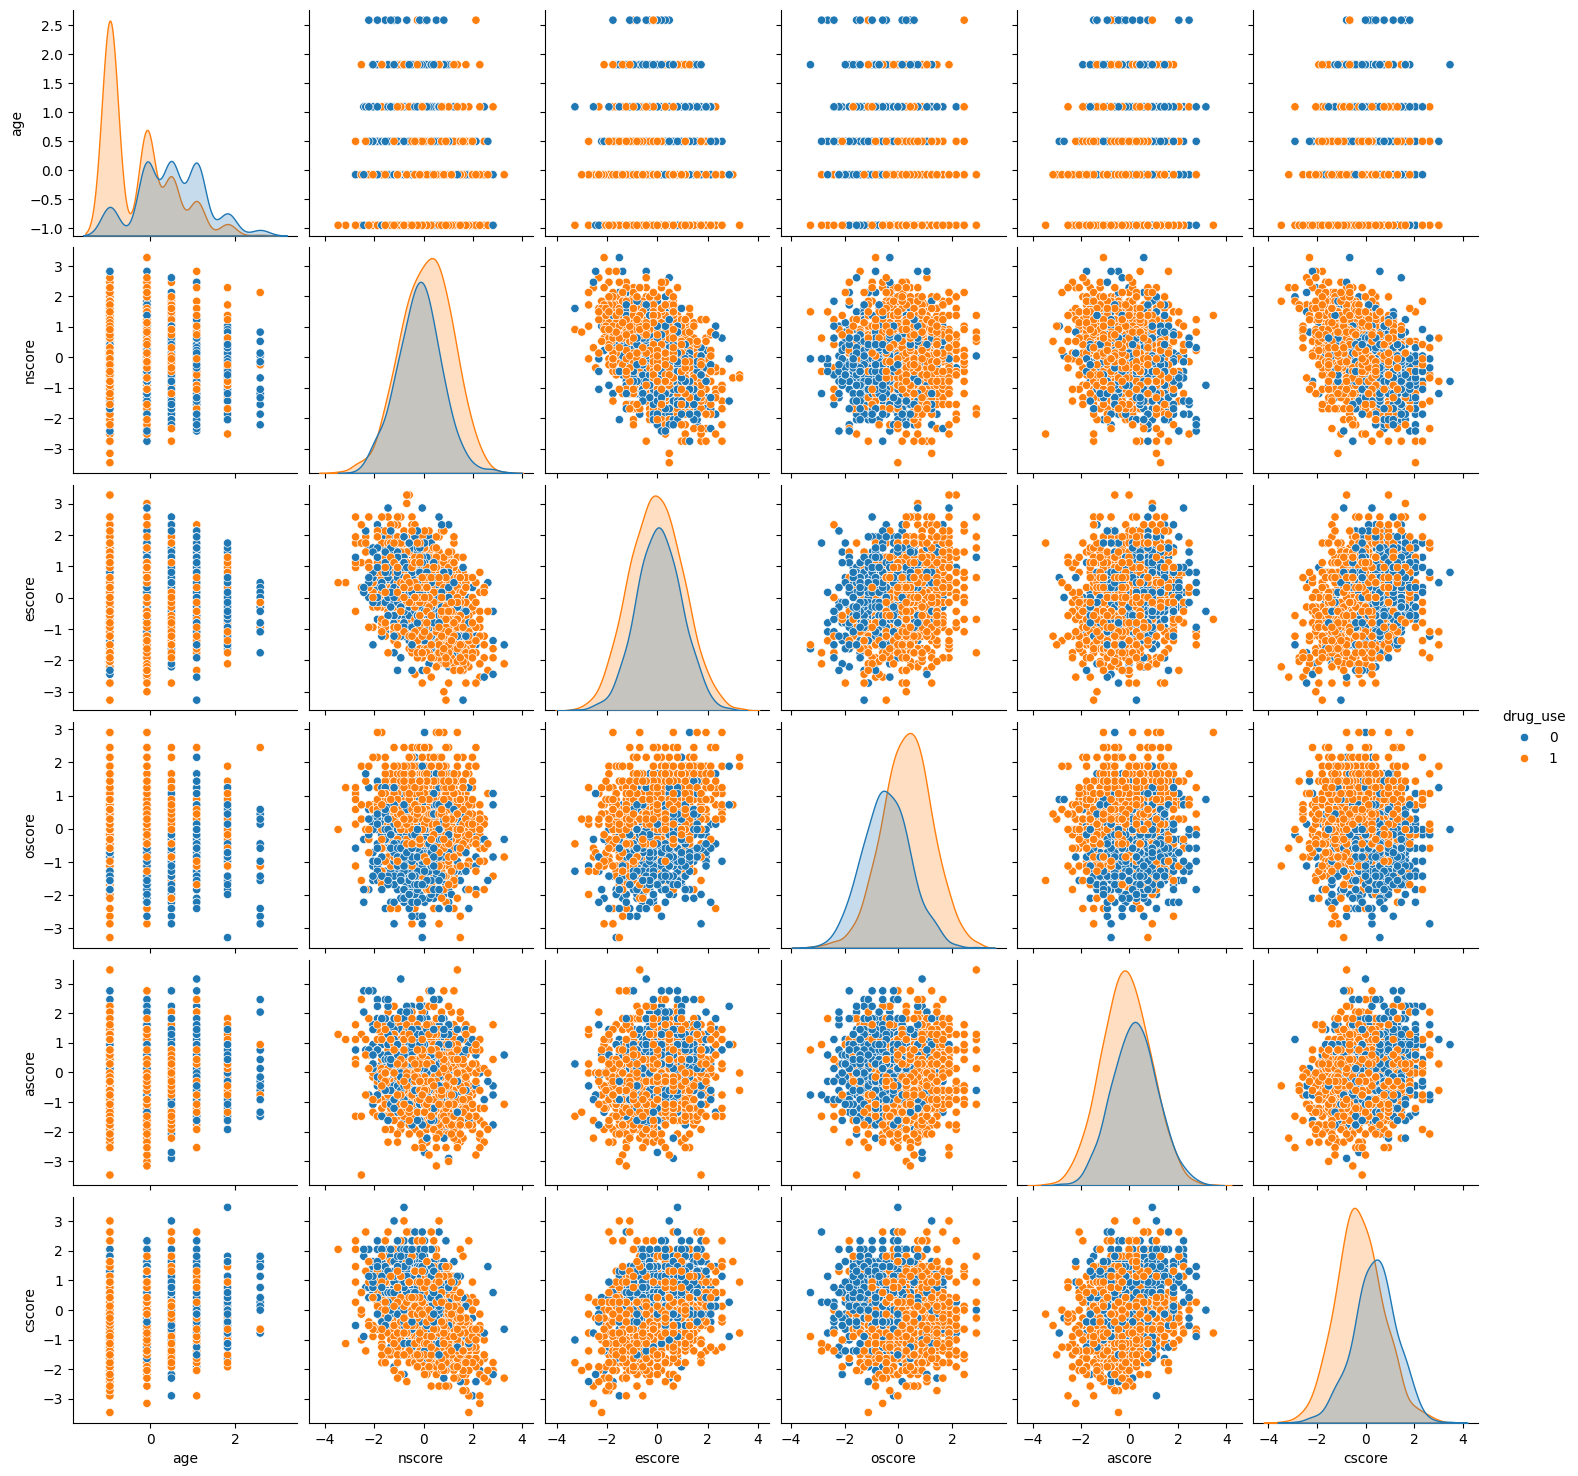

In [17]:
# Pair plot for selected features
selected_features = ['age', 'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'drug_use']
sns.pairplot(df[selected_features], hue='drug_use', diag_kind='kde')
plt.show()

Relationships Between Features and `illicit_drug_use`:

In [18]:
for col in ['age', 'gender', 'education']:
    print(f"Distribution of {col} by illicit_drug_use:")
    print(dfMapped.groupby([col, 'drug_use']).size().unstack())


Distribution of age by illicit_drug_use:
drug_use    0    1
age               
18-24      82  561
25-34     207  274
35-44     205  151
45-54     205   89
55-64      63   30
65+        16    2
Distribution of gender by illicit_drug_use:
drug_use    0    1
gender            
Female    527  415
Male      251  692
Distribution of education by illicit_drug_use:
drug_use             0    1
education                  
Doctorate           53   36
Left at 16          48   51
Left at 17           9   21
Left at 18          26   74
Left before 16       9   19
Masters degree     184   99
Professional cert  136  134
Some college        68  438
University degree  245  235


### Dataset Overview
The dataset contains **1,885 rows and 30 columns**, representing individuals' demographic information, personality traits, and behavioral attributes. It is well-suited for supervised learning as it includes both features and a binary target variable (`drug_use`).

#### Key Features:
1. **Demographic Attributes**:
   - `age`: Encoded age groups (e.g., 18-24, 25-34).
   - `gender`: Encoded as -0.48246 for Male and 0.48246 for Female.
   - `education`: Encoded levels of education, ranging from "Left before 16" to "Doctorate."

2. **Personality Traits**:
   - `nscore`, `escore`, `oscore`, `ascore`, `cscore`: Standardized psychometric scores based on Big Five personality traits.

3. **Behavioral Characteristics**:
   - `impulsive`: Impulsivity score.
   - `ss`: Sensation-seeking score.

4. **Target Variable**:
   - `drug_use`: Binary variable indicating drug use (1 = user, 0 = non-user).

### Target Variable Distribution
The target variable is slightly imbalanced, with approximately **58.7% users** and **41.3% non-users**.


#### **Logistic Regression**

-   **Type**: Linear Model

-   **Best For**:

    -   Simple relationships between predictors and the target variable.
    -   Interpretable models with clear feature importance (via coefficients).
    -   Problems with linearly separable data.
-   **Pros**:

    -   Easy to implement and interpret.
    -   Computationally efficient and fast to train.
    -   Performs well with simple or moderately complex datasets.
    -   Naturally outputs probabilities for classification.
-   **Cons**:

    -   Assumes linearity between predictors and the target.
    -   Sensitive to multicollinearity among features.
    -   May struggle with non-linear decision boundaries.

In [19]:
# Define features (X) and target (y)
X = dfDrugUse.drop('drug_use', axis=1)  # Features
y = dfDrugUse['drug_use']       # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:
# Initialize Logistic Regression model
logistic_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced')

# Train the model
logistic_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

In [21]:
# Predict on the test set
y_pred = logistic_model.predict(X_test)
y_proba = logistic_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC-AUC

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       156
           1       0.88      0.81      0.84       221

    accuracy                           0.82       377
   macro avg       0.82      0.82      0.82       377
weighted avg       0.83      0.82      0.82       377

Confusion Matrix:
[[131  25]
 [ 42 179]]


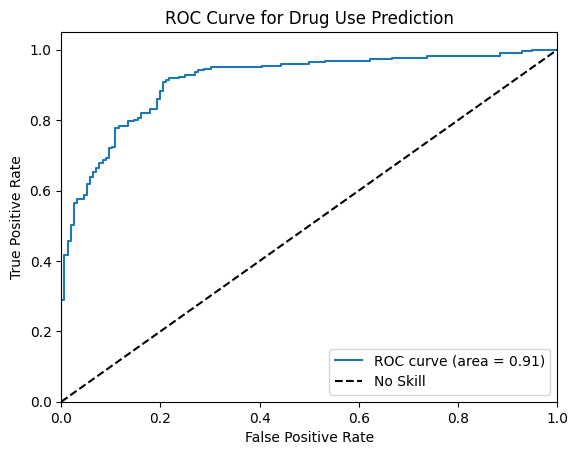

In [22]:
# Predict probabilities on the test set
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1] 

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Drug Use Prediction')
plt.legend()
plt.show()

In [ ]:
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']}
grid = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train, y_train)
print(f"Best Parameters: {grid.best_params_}")
print(f"Best ROC-AUC Score: {grid.best_score_}")

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best ROC-AUC Score: 0.9136074623778778


In [24]:
best_logistic_model = LogisticRegression(C=10, penalty='l2', solver='lbfgs')
best_logistic_model.fit(X_train, y_train)
# Predict on the test set
y_pred = best_logistic_model.predict(X_test)
y_proba = best_logistic_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC-AUC

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       156
           1       0.86      0.86      0.86       221

    accuracy                           0.84       377
   macro avg       0.83      0.83      0.83       377
weighted avg       0.84      0.84      0.84       377

Confusion Matrix:
[[126  30]
 [ 31 190]]


#### **Random Forest**

-   **Type**: Ensemble Model (Bagging)

-   **Best For**:

    -   Complex, non-linear relationships.
    -   Handling missing data and unbalanced datasets.
    -   Feature importance analysis.
-   **Pros**:

    -   Can capture non-linear patterns and interactions between features.
    -   Robust to overfitting with enough trees.
    -   Automatically handles feature scaling and normalization.
    -   Resistant to outliers and noise.
-   **Cons**:

    -   Can be slower to train for large datasets.
    -   Interpretability is lower compared to simpler models like Logistic Regression.
    -   May require hyperparameter tuning (e.g., number of trees, max depth) for optimal performance.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    max_depth=None,  # Allow trees to grow fully
)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [26]:
# Predict on the test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC-AUC

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       156
           1       0.87      0.88      0.87       221

    accuracy                           0.85       377
   macro avg       0.85      0.85      0.85       377
weighted avg       0.85      0.85      0.85       377

ROC-AUC Score: 0.9076894071237963
Confusion Matrix:
[[126  30]
 [ 26 195]]


In [ ]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=2
)
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best ROC-AUC Score: {grid_search.best_score_}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best ROC-AUC Score: 0.9102418832664746


In [28]:
best_rf_model = RandomForestClassifier(
    n_estimators=200,  # Number of trees
    random_state=42,
    min_samples_leaf=2,  # Minimum samples in leaf nodes
    min_samples_split=10,  # Minimum samples to split nodes
    class_weight='balanced',  # Handle class imbalance
    max_depth=10, 
)

# Train the model
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [29]:
# Predict on the test set
y_pred = best_rf_model.predict(X_test)
y_proba = best_rf_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC-AUC

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       156
           1       0.88      0.86      0.87       221

    accuracy                           0.85       377
   macro avg       0.84      0.84      0.84       377
weighted avg       0.85      0.85      0.85       377

ROC-AUC Score: 0.914955331244924
Confusion Matrix:
[[130  26]
 [ 32 189]]


#### **Support Vector Machine (Soft Margin)**

-   **Type**: Kernel-based Model

-   **Best For**:

    -   High-dimensional data.
    -   Non-linear decision boundaries (via kernel functions).
    -   Problems where a soft margin (allowing some misclassifications) is beneficial.
-   **Pros**:

    -   Effective for high-dimensional spaces and small datasets.
    -   Can model complex relationships using kernels (e.g., radial basis function, polynomial).
    -   Well-suited for imbalanced datasets with proper tuning (e.g., class weights).
-   **Cons**:

    -   Computationally expensive for large datasets.
    -   Sensitive to the choice of hyperparameters (e.g., kernel type, `C` parameter).
    -   Less interpretable compared to Logistic Regression or Random Forest.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train SVM with default hyperparameters
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Cross-validation
scores = cross_val_score(svm_model, X_train, y_train, cv=5)
print("Cross-validation mean accuracy: {:.3f}".format(np.mean(scores)))


Cross-validation mean accuracy: 0.836


In [32]:
# Predict on the test set
y_pred = svm_model.predict(X_test)
y_proba = svm_model.decision_function(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc}")


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       156
           1       0.86      0.86      0.86       221

    accuracy                           0.84       377
   macro avg       0.83      0.83      0.83       377
weighted avg       0.84      0.84      0.84       377

Confusion Matrix:
[[124  32]
 [ 30 191]]
ROC-AUC Score: 0.8974649031210117


In [33]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    svm = SVC(C=1.0, kernel=kernel, gamma='scale', random_state=42)
    scores = cross_val_score(svm, X_train, y_train, cv=5)
    print(f"kernel = {kernel}, cross-val mean-accuracy: {np.mean(scores):.3f}")


kernel = linear, cross-val mean-accuracy: 0.839
kernel = poly, cross-val mean-accuracy: 0.810
kernel = rbf, cross-val mean-accuracy: 0.836
kernel = sigmoid, cross-val mean-accuracy: 0.796


In [34]:
# Define the parameter grid
param_grid = {
    'C': np.logspace(-5, 5, num=11, base=2),  # C values: 2^-5 to 2^5
    'gamma': np.logspace(-5, 5, num=11, base=2)  # gamma values: 2^-5 to 2^5
}

# GridSearchCV for hyperparameter tuning
grid = GridSearchCV(
    estimator=SVC(kernel='linear', probability=True, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1
)

# Fit the grid search to the data
grid.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy
print("Best parameters found: ", grid.best_params_)
print("Best cross-validation ROC-AUC: {:.3f}".format(grid.best_score_))

# Use the best model for predictions
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Test set accuracy of the best model: {:.3f}".format(best_model.score(X_test, y_test)))


Fitting 5 folds for each of 121 candidates, totalling 605 fits
Best parameters found:  {'C': np.float64(2.0), 'gamma': np.float64(0.03125)}
Best cross-validation ROC-AUC: 0.914
Test set accuracy of the best model: 0.828


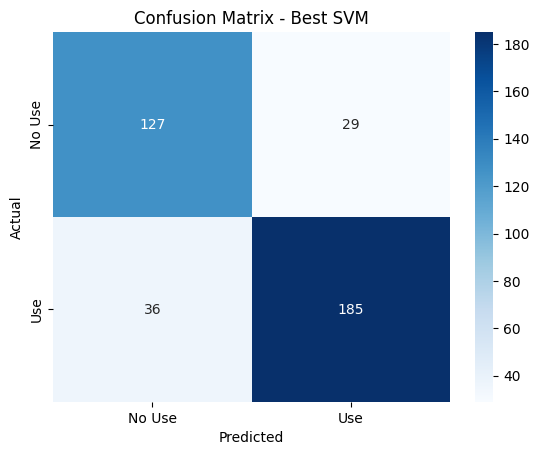

In [35]:
# Confusion matrix for the best model
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=['No Use', 'Use'], yticklabels=['No Use', 'Use'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best SVM')
plt.show()


#### **k-Nearest Neighbors (kNN)**

-   **Type**: Instance-based Learning

-   **Best For**:

    -   Simple datasets with clear clusters or patterns.
    -   When interpretability isn't a priority but simplicity is.
-   **Pros**:

    -   Easy to implement.
    -   Makes no assumptions about the data distribution.
    -   Adapts naturally to non-linear decision boundaries.
-   **Cons**:

    -   Computationally expensive for large datasets.
    -   Sensitive to irrelevant features and feature scaling.
    -   Performance depends heavily on the choice of `k`.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize KNN with K=3
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
print("Classification Report for K=3:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for K=3:")
print(conf_matrix)


Classification Report for K=3:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       156
           1       0.84      0.83      0.83       221

    accuracy                           0.80       377
   macro avg       0.80      0.80      0.80       377
weighted avg       0.80      0.80      0.80       377

Confusion Matrix for K=3:
[[120  36]
 [ 38 183]]


In [ ]:
# Test different values of K
acc = []
allks = range(1, 50, 2)

for k in allks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    acc.append(scores.mean())
    print(f"K = {k}, Cross-Validation Accuracy: {scores.mean():.3f}")


K = 1, Cross-Validation Accuracy: 0.774
K = 3, Cross-Validation Accuracy: 0.790
K = 5, Cross-Validation Accuracy: 0.810
K = 7, Cross-Validation Accuracy: 0.814
K = 9, Cross-Validation Accuracy: 0.814
K = 11, Cross-Validation Accuracy: 0.823
K = 13, Cross-Validation Accuracy: 0.823
K = 15, Cross-Validation Accuracy: 0.815
K = 17, Cross-Validation Accuracy: 0.816
K = 19, Cross-Validation Accuracy: 0.821
K = 21, Cross-Validation Accuracy: 0.824
K = 23, Cross-Validation Accuracy: 0.826
K = 25, Cross-Validation Accuracy: 0.827
K = 27, Cross-Validation Accuracy: 0.828
K = 29, Cross-Validation Accuracy: 0.830
K = 31, Cross-Validation Accuracy: 0.830
K = 33, Cross-Validation Accuracy: 0.826
K = 35, Cross-Validation Accuracy: 0.826
K = 37, Cross-Validation Accuracy: 0.825
K = 39, Cross-Validation Accuracy: 0.825
K = 41, Cross-Validation Accuracy: 0.824
K = 43, Cross-Validation Accuracy: 0.823
K = 45, Cross-Validation Accuracy: 0.827
K = 47, Cross-Validation Accuracy: 0.824
K = 49, Cross-Validat

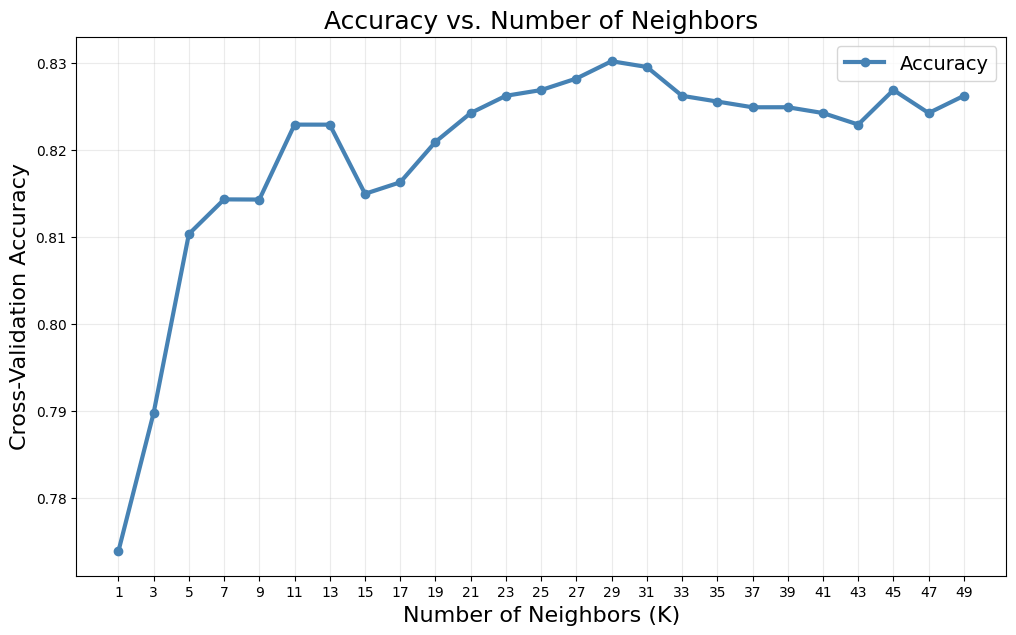

In [39]:
# Plot accuracy vs K
plt.figure(figsize=(12, 7))
plt.plot(allks, acc, marker="o", color="steelblue", lw=3, label="Accuracy")
plt.xlabel("Number of Neighbors (K)", fontsize=16)
plt.ylabel("Cross-Validation Accuracy", fontsize=16)
plt.title("Accuracy vs. Number of Neighbors", fontsize=18)
plt.xticks(range(1, 50, 2))
plt.grid(alpha=0.25)
plt.legend(fontsize=14)
plt.show()


In [40]:
# Optimal K (max accuracy)
optimal_k = 29
print(f"Optimal K: {optimal_k}")

# Train KNN with the optimal K
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)

# Predict on the test set
y_pred_optimal = knn_optimal.predict(X_test)

# Evaluate the optimal KNN model
print(f"Classification Report for K={optimal_k}:")
print(classification_report(y_test, y_pred_optimal))

# Confusion matrix for optimal K
conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
print(f"Confusion Matrix for K={optimal_k}:")
print(conf_matrix_optimal)


Optimal K: 29
Classification Report for K=29:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       156
           1       0.88      0.83      0.85       221

    accuracy                           0.83       377
   macro avg       0.83      0.83      0.83       377
weighted avg       0.84      0.83      0.83       377

Confusion Matrix for K=29:
[[130  26]
 [ 37 184]]


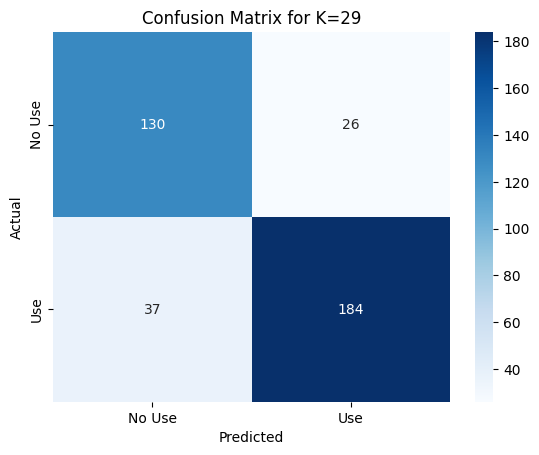

In [ ]:
# Confusion matrix heatmap
sns.heatmap(conf_matrix_optimal, annot=True, fmt='d', cmap='Blues', xticklabels=['No Use', 'Use'], yticklabels=['No Use', 'Use'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for K={optimal_k}')
plt.show()
